In [2]:
!nvidia-smi

Thu Oct 16 07:04:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt

## Chapter 9 - Simulation of Diffusions
Refinement of Euler schemes for SDEs to reduce discretization bias in the simulation of diffusions.
How to combine variance reduction techniques with discretization schemes to further improve the efficiency of Monte Carlo methods for SDEs.

### Numerical Examples

**Example 9.3. Comparison of Euler Scheme and Milstein Scheme.** Suppose that
$X$ is a geometric Brownian motion with drift $r$ and volatility $\sigma$. That is,

$$dX_t = rX_t dt + \sigma X_t dW_t.$$

Use the Euler scheme and the Milstein scheme to appoximate $E[X_T]$. Compare the performance.

In [4]:
def example_9_3_gpu_batched(batch_size=10_000, n_batches=1_000):
    cp.random.seed(4198)

    r, sig, T, X_0 = 0.12, 0.2, 1.0, 50
    m_values = [5, 10, 20, 40, 60, 80, 100]
    h_values = [T / m for m in m_values]

    # ---- helper to compute mean over batches ----
    def batched_mean(func, m):
        batch_means = []
        for it in range(n_batches):
            batch_means.append(func(m))
        return cp.mean(cp.array(batch_means))

    # ---- Euler scheme ----
    def euler_scheme_error(m):
        h = T / m
        X = cp.full(batch_size, X_0, dtype=cp.float32)
        benchmark = cp.full(batch_size, X_0, dtype=cp.float32)
        for _ in range(m):
            Z = cp.random.normal(size=batch_size, dtype=cp.float32)
            X += r * X * h + sig * X * cp.sqrt(h) * Z
            benchmark *= cp.exp((r - 0.5 * sig**2) * h + sig * cp.sqrt(h) * Z)
        return cp.mean(cp.abs(X - benchmark))

    # ---- Milstein scheme ----
    def milstein_scheme_error(m):
        h = T / m
        X = cp.full(batch_size, X_0, dtype=cp.float32)
        benchmark = cp.full(batch_size, X_0, dtype=cp.float32)
        for _ in range(m):
            Z = cp.random.normal(size=batch_size, dtype=cp.float32)
            X += (r * X * h
                  + sig * X * cp.sqrt(h) * Z
                  + 0.5 * sig**2 * X * h * (Z**2 - 1))
            benchmark *= cp.exp((r - 0.5 * sig**2) * h + sig * cp.sqrt(h) * Z)
        return cp.mean(cp.abs(X - benchmark))

    # ---- Run all m values ----
    euler_errors     = cp.array([batched_mean(euler_scheme_error, m) for m in m_values])
    milstein_errors  = cp.array([batched_mean(milstein_scheme_error, m) for m in m_values])

    # ---- Back to CPU for DataFrame ----
    df = pd.DataFrame({
        'm': [str(m) for m in m_values],
        'Euler': euler_errors.get(),
        'Milstein': milstein_errors.get()
    }, index=['' for _ in m_values]).T

    return df, euler_errors.get(), milstein_errors.get(), h_values


In [5]:
df, euler_err, milstein_err, h = example_9_3_gpu_batched(batch_size=10_000, n_batches=1000)
print(df)


                                                                              
m                5        10        20        40        60        80       100
Euler     0.561586  0.399082  0.283173  0.200679  0.163909  0.142059  0.127122
Milstein  0.221006  0.112042  0.056464  0.028336  0.018897  0.014193  0.011356


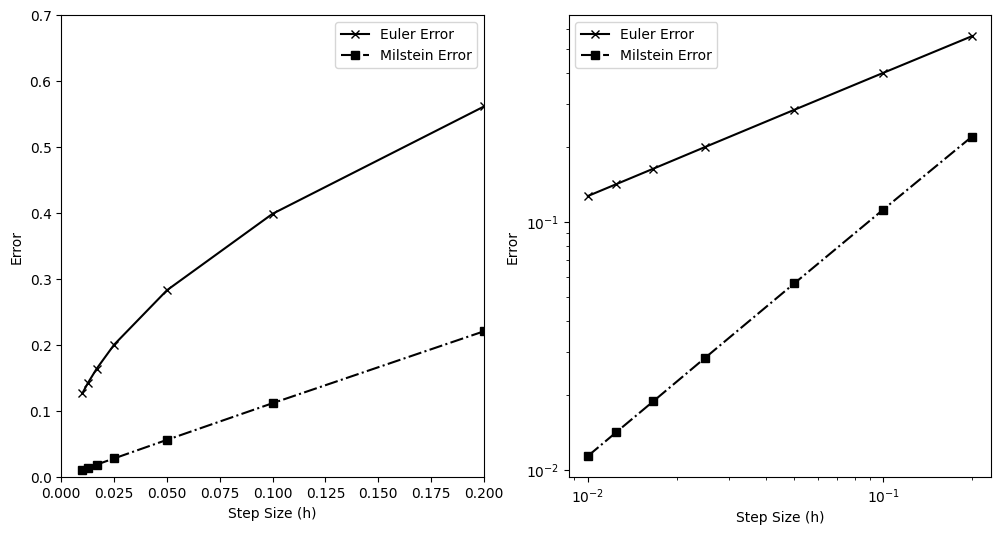

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axes

# Plot step size h against euler error and milstein error
ax1.plot(h, euler_err, label='Euler Error', marker='x', color='black')
ax1.plot(h, milstein_err, label='Milstein Error', marker='s', linestyle='-.', color='black')
ax1.set_xlabel('Step Size (h)')
ax1.set_ylabel('Error')

ax1.set_ylim(0, 0.7)
ax1.set_xlim(0, 0.2)

# Plot step size h against euler error and milstein error on loglog
ax2.loglog(h, euler_err, label='Euler Error', marker='x', color='black')
ax2.loglog(h, milstein_err, label='Milstein Error', marker='s', linestyle='-.', color='black')

# set x, y labels
ax2.set_xlabel('Step Size (h)')
ax2.set_ylabel('Error')

ax1.legend()
ax2.legend()

fig.show()


**Example 9.4. No Discretization Error.** Consider a discretely monitored
lookback call option with maturity $T$ and floating strike price. The option
payoff is
$$X = S_T - \min_{i=1,...,m} S_{t_i} $$
where $0 = t_0 < t_1 < · · · < t_m = T$ are given dates. Assume that the risk-free interest rate $r$ is a constant and the stock price $S$ satisfies the stochastic differential equation
$$dS_t = rS_t dt + θ(t)S_t d W_t$$
for some deterministic function $θ(t)$ under the risk-neutral probability
measure. Design a discretization scheme without discretization error and
estimate the option price.

In [39]:
def example_9_4_gpu(n=1_000_000):
    cp.random.seed(4198)

    S_0, r, T, a, b = 20.0, 0.05, 1.0, 0.4, 0.3
    theta = lambda t: cp.sqrt(a**2 + b**2 * cp.sin(2*cp.pi*t/T))

    m_values = [5, 10, 20]

    # ---- Euler scheme ----
    def euler_scheme_error(m):
        t = cp.linspace(0, T, m + 1)
        dt = T / m
        S = cp.full(n, S_0, dtype=cp.float64)
        S_min = cp.full(n, S_0, dtype=cp.float64)

        for i in range(m):
            sig = theta(t[i])
            Z = cp.random.normal(size=n, dtype=cp.float64)
            S += r * S * dt + sig * S * cp.sqrt(dt) * Z
            S_min = cp.minimum(S_min, S)

        payoff = cp.exp(-r * T) * (S - S_min)
        return cp.mean(payoff), cp.std(payoff, ddof=1) / cp.sqrt(n)

    # ---- "Exact" scheme (log-space integration) ----
    def exact_scheme_error(m):
        # same grid, but treat volatility as continuous
        t = cp.linspace(0, T, m + 1)
        dt = T / m
        Y = cp.full(n, cp.log(S_0), dtype=cp.float64)
        S_min = cp.full(n, S_0, dtype=cp.float64)

        S = None
        for i in range(m):
            sig2 = a**2 * dt + b**2*T/(2*cp.pi) * (cp.cos(2*cp.pi * t[i]/T) - cp.cos(2*cp.pi*t[i+1]/T))
            sig = cp.sqrt(sig2)
            Z = cp.random.normal(size=n, dtype=cp.float64)
            Y += r * dt - 0.5 * sig2 + sig * Z
            S = cp.exp(Y)
            S_min = cp.minimum(S_min, S)

        payoff = cp.exp(-r * T) * (S - S_min)
        return cp.mean(payoff), cp.std(payoff, ddof=1) / cp.sqrt(n)

    # ---- Run all m values ----
    euler_results, euler_se = zip(*[euler_scheme_error(m) for m in m_values])
    exact_results, exact_se = zip(*[exact_scheme_error(m) for m in m_values])

    euler_results, euler_se = cp.array(euler_results), cp.array(euler_se)
    exact_results, exact_se = cp.array(exact_results), cp.array(exact_se)

    # ---- Back to CPU for DataFrame ----
    df = pd.DataFrame({
        'm': [str(m) for m in m_values],
        'Euler Mean': euler_results.get(),
        'Euler SE': euler_se.get(),
        'Exact Mean': exact_results.get(),
        'Exact SE': exact_se.get()
    }).set_index('m')

    return df

In [40]:
df = example_9_4_gpu(n=1_000_000)
df

,Euler Mean,Euler SE,Exact Mean,Exact SE
m,,,,
5,4.714145,0.005754,4.714123,0.006174
10,5.062024,0.005973,5.059127,0.006205
20,5.333318,0.006118,5.328886,0.006256


**Example 9.5.** Simulating a process with sign constraints. The majority of
the diffusion processes that are used for modeling stock prices, interest rate,
volatility, and other financial entities are nonnegative. This property may
fail for the time discretized approximating processes, which sometimes re-
sults in necessary modifications of the discretization scheme. To be more
concrete, consider the Cox–Ingersoll–Ross interest rate model [6] where the
short rate $\{r_t\}$ satisfies the stochastic differential equation

$$dr_t = a(b - r_t) dt + \sigma \sqrt{r_t} d W_t$$

for some positive constants $a$, $b$, and $σ$ such that $2ab ≥ σ^2$. Estimate the
price of a zero-coupon bond with maturity $T$ and payoff $1.

**Example 9.6. Method of conditioning.** Suppose that under the risk-neutral
probability measure, the stock price satisfies the stochastic differential
equation
$$\frac{d S_t}{S_t} = r_t dt + σ dW_t.$$
The short rate $\{r_t\}$ is assumed to be mean-reverting and satisfy the stochastic differential equation

$$dr_t = a(b - r_t) dt + θ r_t dB_t,$$

for some positive constants $a$, $b$, and $θ$. Assume that $(W, B)$ is a two-dimensional Brownian motion with covariance matrix
$$ \Sigma = \begin{bmatrix} 1 & \rho \\ \rho & 1 \end{bmatrix}. $$

Estimate the price of a call option with maturity $T$ and strike price $K$.

**Example 9.7. Control variate method by means of artificial dynamics.**
Consider a stochastic volatility model (the volatility is denoted by $\theta$) where
the risk-free interest rate is a constant r and under the risk-neutral proba-
bility measure,
$$dS_t = r S_t dt +\theta_t S_t d W_t,$$
$$dθ_t = a(\theta − \theta_t) d_t+ \beta d B_t,$$
for some positive constants $a$, $\theta$, and $\beta$. Here $(W, B)$ is a two-dimensional
Brownian motion with covariance matrix
$$\Sigma = \begin{bmatrix}1 & \rho \\ \rho & 1 \end{bmatrix}$$
Estimate the price of a call option with strike price $K$ and maturity $T$.

**Example 9.8. Importance sampling and cross-entropy method.** Assume
that the risk-free interest rate $r$ is a constant and the underlying stock price
is a constant elasticity of variance (CEV) process under the risk-neutral
probability measure, that is,
$$d S_t = r S_t dt +\sigma S^\gamma_t d W_t$$
for some $0.5 \leq \gamma < 1$. Estimate the price of a call option with maturity $T$
and strike price $K$.

**Example 9.9. Importance sampling and cross-entropy method.**
Consider the Heston model where the risk-free interest rate is a constant $r$ and under
the risk-neutral probability measure
$$d S_t = r S_t dt + \sqrt{\theta_t}S_t d W_t,$$
$$ d \theta_t = a(b − \theta_t) dt +\sigma \sqrt{\theta_t} d B_t,$$
for some positive constants $a$, $b$, and $\sigma$ such that $2ab \geq \sigma^2$. Here $(W, B)$ is a
two-dimensional Brownian motion with covariance matrix
$$\Sigma = \begin{bmatrix}1 & \rho \\ \rho & 1 \end{bmatrix}$$
Estimate the price of a call option with maturity T and strike price K.